In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import scipy.stats
import time
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import matplotlib.animation as animation
%matplotlib nbagg

### Load in data

In [2]:
with open("id_to_player.json") as f:
    for l in f:
        id_to_player = json.loads(l)
id_to_player = {int(k): v for (k, v) in id_to_player.items()}
with open("player_to_id.json") as f:
    for l in f:
        player_to_id = json.loads(l)
player_to_id = {k: int(v) for (k, v) in player_to_id.items()}

In [3]:
with open("id_to_team.json") as f:
    for l in f:
        id_to_team = json.loads(l)
id_to_team = {int(k): v for (k, v) in id_to_team.items()}        
with open("team_to_id.json") as f:
    for l in f:
        team_to_id = json.loads(l)
team_to_id = {k: int(v) for (k, v) in team_to_id.items()}
team_to_winpct = json.load(open("team_to_winpct.json"))
team_to_abbrev = json.load(open("team_to_abbrev.json"))

### Zones
<img src="zones.png">

<IPython.core.display.Javascript object>


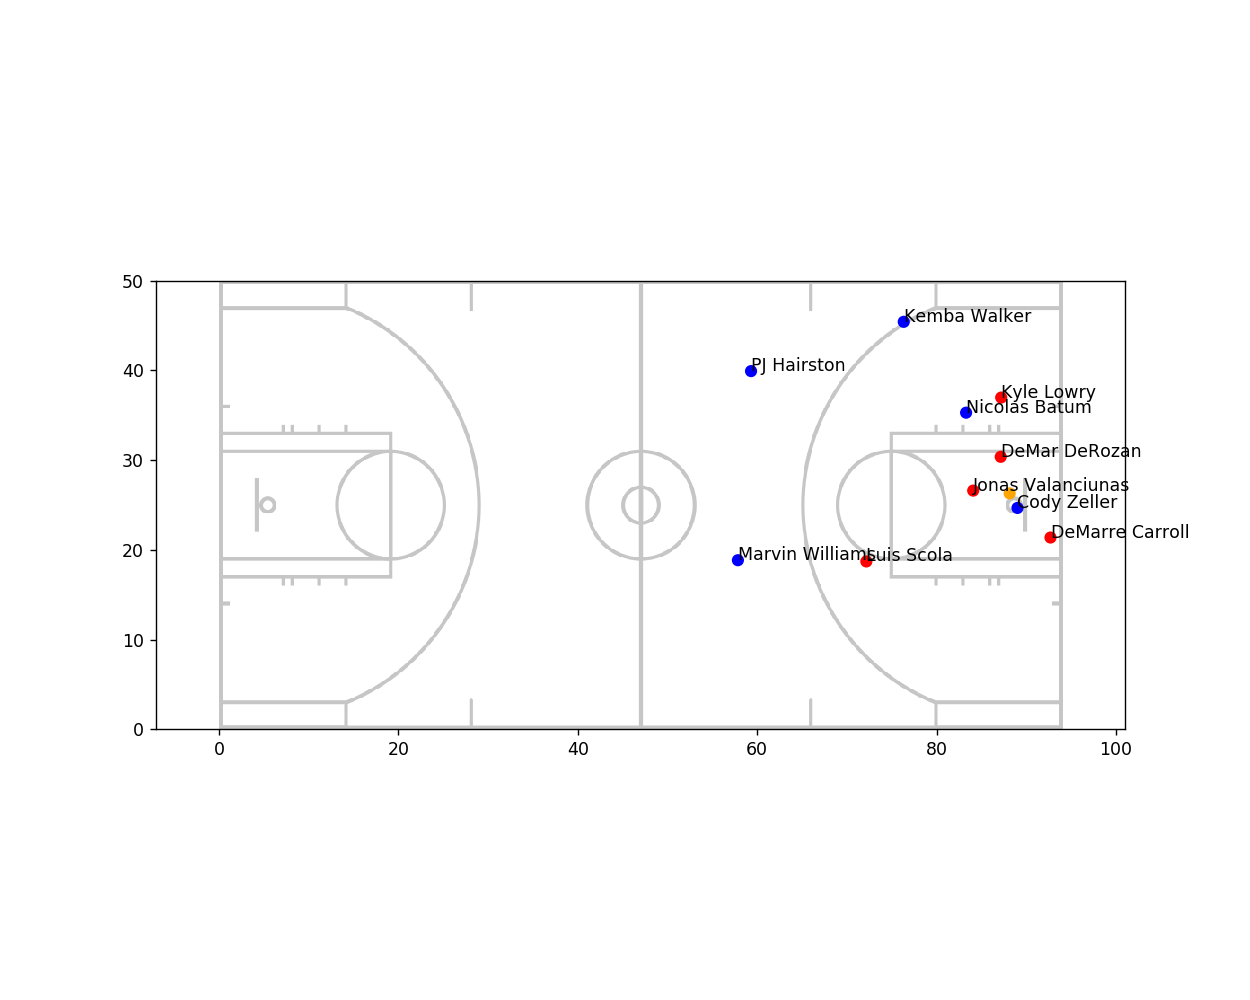

In [6]:
court = plt.imread("fullcourt.png")
counter = 0
xs = []
ys = []
n = []
for root, dirs, files in os.walk(".\data"):
    counter += 1
    if counter > 2:
        break
    for fil in files:
        with open(os.path.join(root, fil)) as f:
            for l in f:
                line = json.loads(l)
                gid = line["gameid"]
                for mom in line["events"][4]["moments"]:
                    n = [id_to_player[val[1]] for val in mom[5]]
                    xs.append([val[2] for val in mom[5]])
                    ys.append([val[3] for val in mom[5]])
                break
                
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(1,1,1)
colors = ["orange"] + ["red"]*5 + ["blue"]*5

def animate(i):
    xar = xs[i]
    yar = ys[i]
    ax1.clear()
    ax1.set_xlim([-7, 101])
    ax1.set_ylim([0, 50])
    plt.imshow(court, zorder=0, extent=[0,94,50,0])
    ax1.scatter(xar,yar, color=colors)
    for j, txt in enumerate(n):
        ax1.annotate(txt, (xs[i][j],ys[i][j]), size=10)
ani = animation.FuncAnimation(fig, animate, interval=100)
plt.show()

### Function to find distance from one point to another

In [4]:
def distance(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

### Function to return the zone of a given coordinate

In [5]:
def get_zone(x, y):
    if x < 0 or x > 94:
        return 0
    elif 19 <= y <= 31 and (x < 19 or x > 75):
        return 1 
    elif (0 <= x <= 14 or 80 <= x <= 94) and 0 <= y <= 3:
        return 2
    elif (0 <= x <= 14 or 80 <= x <= 94) and 47 <= y <= 50:
        return 3
    elif (0 <= x <= 14 or 80 <= x <= 94) and 3 < y < 19:
        return 4
    elif (0 <= x <= 14 or 80 <= x <= 94) and 31 < y < 47:
        return 5
    elif ((x < 47 and (x-5.25)**2 + (y-25)**2 < 23.75**2) or (x >= 47 and (x-88.75)**2 + (y-25)**2 < 23.75**2)) and y <= 25:
        return 6
    elif ((x < 47 and (x-5.25)**2 + (y-25)**2 < 23.75**2) or (x >= 47 and (x-88.75)**2 + (y-25)**2 < 23.75**2)) and y > 25:
        return 7
    elif y <= 25:
        return 8
    else:
        return 9

### Function to output transition matrices for a team's movements 

In [6]:
def transitions(team_name, num_games=None, p=True):
    abbrev = team_to_abbrev[team_name]
    team_id = team_to_id[team_name]
    transition_dict = {}
    seen_moments = set()

    count = 0
    for root, dirs, files in os.walk(".\data"):
        if abbrev in root:
            for fil in files:
                with open(os.path.join(root, fil)) as f:
                    if num_games and count >= num_games:
                        return transition_dict
                    if p:
                        print root
                    count += 1
                    for l in f:
                        line = json.loads(l)
                        for i in range(len(line["events"])):
                            for mom in line["events"][i]["moments"]:
                                mom_tuple = (mom[2], mom[3], mom[5][0][2], mom[5][0][3])
                                if mom_tuple not in seen_moments:
                                    for val in mom[5]:
                                        player = val[1]
                                        team = val[0]
                                        if team == team_id and player != -1:
                                            zone = get_zone(val[2], val[3])
                                            if team not in transition_dict:
                                                transition_dict[team] = {}
                                            if player not in transition_dict[team]:
                                                transition_dict[team][player] = [np.zeros(shape=(10, 10)), zone]
                                            else:
                                                if transition_dict[team][player][1] != zone:
                                                    transition_dict[team][player][0][transition_dict[team][player][1], zone] += 1
                                            transition_dict[team][player][1] = zone
                                    seen_moments.add(mom_tuple)
    return transition_dict

### Outputs distances for each player to ball for each moment

In [7]:
def distances_to_ball(team_name, team_specific=True, num_games=None, p=True):
    #p = scipy.stats.norm(1, 1)
    abbrev = team_to_abbrev[team_name]
    moment_dists = []
    team_id = team_to_id[team_name]
    seen_moments = set()

    count = 0
    for root, dirs, files in os.walk(".\data"):
        if abbrev in root:
            for fil in files:
                with open(os.path.join(root, fil)) as f:
                    if num_games and count >= num_games:
                        return moment_dists
                    if p:
                        print root
                    count += 1
                    for l in f:
                        line = json.loads(l)
                        for i in range(len(line["events"])):
                            for mom in line["events"][i]["moments"]:
                                mom_tuple = (mom[2], mom[3], mom[5][0][2], mom[5][0][3])
                                if mom_tuple not in seen_moments:
                                    ballx = mom[5][0][2]
                                    bally = mom[5][0][3]
                                    dists = []
                                    for val in mom[5]:
                                        team = val[0]
                                        player = val[1]
                                        if player != -1 and player != 0 and (not team_specific or (team == team_id and team_specific)):
                                            dists.append((id_to_player[player], distance(val[2], val[3], ballx, bally), team))
                                            #dists.append((id_to_player[player], p.pdf(distance(val[2], val[3], ballx, bally))))
                                    seen_moments.add(mom_tuple)
                                    if dists:
                                        moment_dists.append(sorted(dists, key=lambda x:x[1]))
    return moment_dists, ball_loc

### Given distances of players at each moment, finds ballhandlers

In [8]:
def get_ballhandlers(moment_dists):
    ballhandlers = []
    for i, mom in enumerate(moment_dists):
        if mom[0][1] > 3:
            team = None
            ballhandler = None
            for j in range(i-1, i-5, -1):
                if j < 0:
                    break
                if ballhandlers[j][0] is None:
                    for ind in range(j, i):
                        ballhandlers[ind] = (None, ballhandlers[ind][1], None)
        else:
            if i == 0 or i > 0 and mom[0][0] == moment_dists[i-1][0][0]:
                ballhandler = mom[0][0]
                team = mom[0][2]
                if i > 0 and ballhandlers[i-1][0] is None:
                    for j in range(i-1, i-5, -1):
                        if j < 0:
                            break
                        if ballhandlers[j][0] == ballhandler:
                            for ind in range(j, i):
                                ballhandlers[ind] = (ballhandler, ballhandlers[ind][1], team)
            else:
                ballhandler = None
                team = None
        ballhandlers.append((ballhandler, mom[0][1], team))
    return ballhandlers

### Finds transition matrices of ballhandlers only

In [9]:
def ballhandler_transitions(team_name, ballhandlers, num_games=None, p=True):
    abbrev = team_to_abbrev[team_name]
    team_id = team_to_id[team_name]
    b_transition_dict = {}
    seen_moments = set()

    moment_num = 0
    count = 0
    for root, dirs, files in os.walk(".\data"):
        if abbrev in root:
            for fil in files:
                with open(os.path.join(root, fil)) as f:
                    if num_games and count >= num_games:
                        return b_transition_dict
                    if p:
                        print root
                    count += 1
                    for l in f:
                        line = json.loads(l)
                        for i in range(len(line["events"])):
                            last_bh = None
                            for mom in line["events"][i]["moments"]:
                                mom_tuple = (mom[2], mom[3], mom[5][0][2], mom[5][0][3])
                                if mom_tuple not in seen_moments:
                                    for val in mom[5]:
                                        team = val[0]
                                        player = val[1]
                                        if moment_num >= len(ballhandlers):
                                            return b_transition_dict
                                        if team == team_id and player != -1 and player != 0 and id_to_player[player] == ballhandlers[moment_num][0]:
                                            zone = get_zone(val[2], val[3])
                                            if team not in b_transition_dict:
                                                b_transition_dict[team] = {}
                                            if player not in b_transition_dict[team]:
                                                b_transition_dict[team][player] = [np.zeros(shape=(11, 11)), zone]
                                            else:
                                                if b_transition_dict[team][player][1] != zone:
                                                    b_transition_dict[team][player][0][b_transition_dict[team][player][1], zone] += 1
                                            b_transition_dict[team][player][1] = zone
                                        elif team == team_id and player != -1 and ballhandlers[moment_num][0] is None and last_bh is not None:
                                            player = player_to_id[last_bh]
                                            if player in b_transition_dict[team]:
                                                b_transition_dict[team][player][0][b_transition_dict[team][player][1], 10] += 1
                                    last_bh = ballhandlers[moment_num][0]       
                                    moment_num += 1
                                    seen_moments.add(mom_tuple)
    return b_transition_dict

In [10]:
player_to_trans_pass = json.load(open("player_to_trans_pass.json"))
player_to_trans_nopass = json.load(open("player_to_trans_nopass.json"))
player_to_norm_trans_pass = json.load(open("player_to_norm_trans_pass.json"))
player_to_norm_trans_nopass = json.load(open("player_to_norm_trans_nopass.json"))

### Visualization of good offense vs bad offense

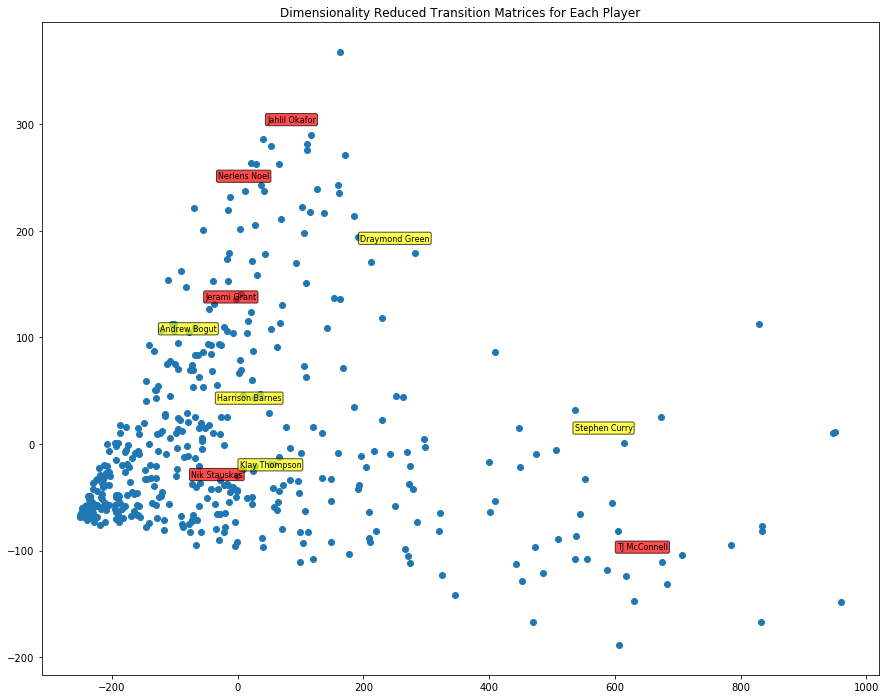

In [11]:
relevant_players = {"Draymond Green", "Stephen Curry", "Klay Thompson", "Harrison Barnes", "Andrew Bogut"}
relevant_players2 = {"Nerlens Noel", "Jerami Grant", "Jahlil Okafor", "Nik Stauskas", "TJ McConnell"}
vals = []
ps = []
for p, mat in player_to_trans_nopass.items():
    ps.append(p)
    vals.append(mat)
t = PCA(n_components=2)
td=t.fit_transform(vals)
plt.figure(figsize=(15, 12))
plt.scatter(td[:, 0], td[:, 1])
for p, x, y in zip(ps, td[:, 0], td[:, 1]):
    if p in relevant_players:
        plt.annotate(p, xy=(x, y), xytext=(-20, 15), size=8, textcoords='offset points', ha='center', va='center', 
                     bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.7))
    if p in relevant_players2:
        plt.annotate(p, xy=(x, y), xytext=(-20, 15), size=8, textcoords='offset points', ha='center', va='center', 
                     bbox=dict(boxstyle='round,pad=0.2', fc='red', alpha=0.7))
plt.title("Dimensionality Reduced Transition Matrices for Each Player")
plt.show()

### Relevant players plotted on PCA reduced transition matrices

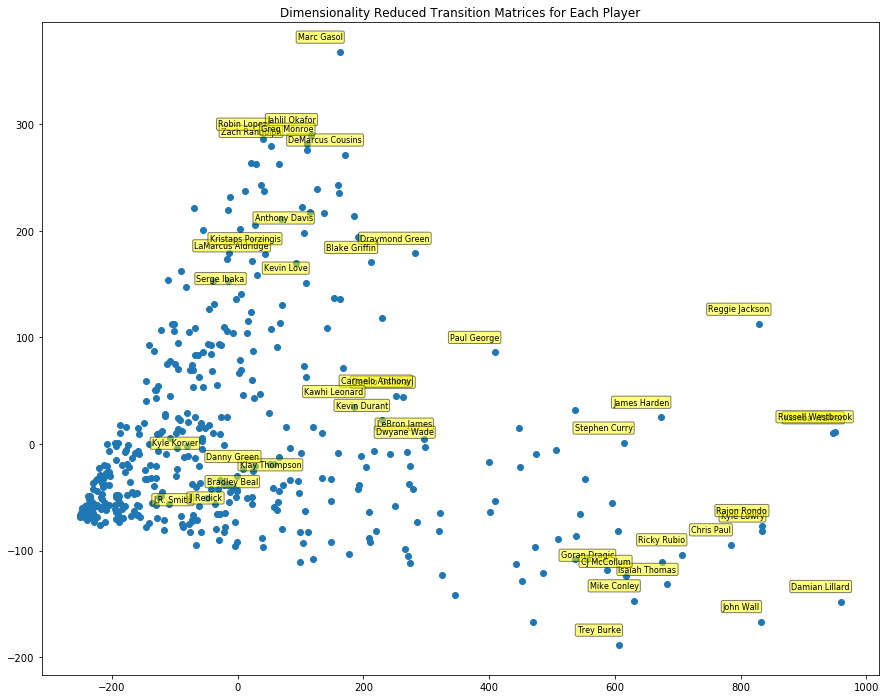

In [12]:
relevant_players = {"Marc Gasol", "Draymond Green", "Blake Griffin", "Reggie Jackson", "Paul George", 
                    "Kevin Durant", "Kawhi Leonard", "Danilo Gallinari", "LeBron James", "Dwyane Wade", 
                    "Carmelo Anthony", "Greg Monroe", "DeMarcus Cousins", "Jahlil Okafor", "Zach Randolph", 
                    "Kristaps Porzingis", "LaMarcus Aldridge", "Russell Westbrook", "James Harden", 
                    "Damian Lillard", "John Wall", "Mike Conley", "Isaiah Thomas", "Stephen Curry", 
                    "Chris Paul", "Rajon Rondo", "Kyle Lowry", "Ricky Rubio", "Anthony Davis", "Klay Thompson", 
                    "Kyle Korver", "Danny Green", "JJ Redick", "Bradley Beal", "J.R. Smith", 
                    "CJ McCollum", "Goran Dragic", "Trey Burke", "Robin Lopez", "Kevin Love", 
                    "Serge Ibaka", "Kemba Walker"}
plt.figure(figsize=(15, 12))
plt.scatter(td[:, 0], td[:, 1])
for p, x, y in zip(ps, td[:, 0], td[:, 1]):
    if p in relevant_players:
        plt.annotate(p, xy=(x, y), xytext=(-20, 15), size=8, textcoords='offset points', ha='center', va='center', 
                     bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5))
plt.title("Dimensionality Reduced Transition Matrices for Each Player")
plt.show()

### Use elbow method to find best k value for k-means

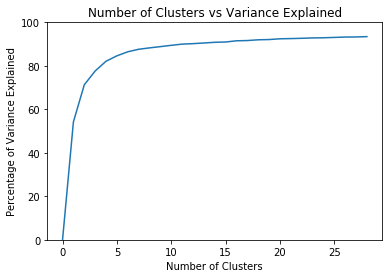

In [13]:
def elbow(df, n):
    kMeansVar = [KMeans(n_clusters=k).fit(df) for k in range(1, n)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(df, cent, "euclidean") for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(df)**2)/df.shape[0]
    bss = tss - wcss
    plt.title("Number of Clusters vs Variance Explained")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Percentage of Variance Explained")
    plt.ylim(0, 100)
    plt.plot(bss/tss*100)
    plt.show()
elbow(np.array(vals), 30)

### Perform K-means on the flattened transition matrices

In [14]:
kmeans = KMeans(n_clusters=5).fit(vals)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
label_to_players = {}
for p, label in zip(ps, labels):
    if label in label_to_players:
        label_to_players[label].append(p)
    else:
        label_to_players[label] = [p]

In [15]:
for players in sorted(label_to_players.values(), key=lambda x:len(x)):
    print players

[u'George Hill', u'Kyle Lowry', u'Isaiah Thomas', u'Michael Carter-Williams', u'Tony Parker', u'John Wall', u'Reggie Jackson', u'Jordan Clarkson', u'Goran Dragic', u'Stephen Curry', u'Rajon Rondo', u'Chris Paul', u'Kemba Walker', u'Mike Conley', u'Jeff Teague', u'Cory Joseph', u'Monta Ellis', u'Zach LaVine', u'James Harden', u'Damian Lillard', u'Jose Calderon', u'CJ McCollum', u'Deron Williams', u'Brandon Knight', u'Elfrid Payton', u'Ricky Rubio', u"D'Angelo Russell", u'Russell Westbrook', u'DeMar DeRozan', u'Emmanuel Mudiay', u'Dennis Schroder', u'TJ McConnell', u'Derrick Rose', u'Trey Burke', u'Jimmy Butler', u'Jrue Holiday']
[u'Pau Gasol', u'Draymond Green', u'Thaddeus Young', u'Kevin Love', u'Nikola Vucevic', u'Jared Sullinger', u'Paul Millsap', u'Jerami Grant', u'DeMarcus Cousins', u'Julius Randle', u'Marc Gasol', u'Brook Lopez', u'Zach Randolph', u'Enes Kanter', u'Al-Farouq Aminu', u'Al Horford', u'Amir Johnson', u'Ersan Ilyasova', u'Jordan Hill', u'Zaza Pachulia', u'DeAndre Jord

### Plot clusters with relevant players

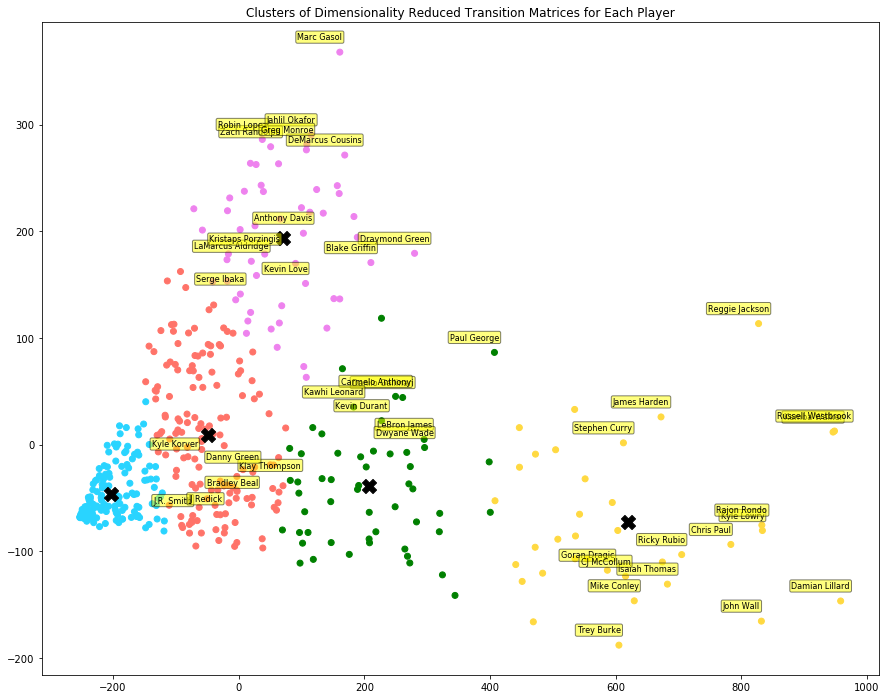

In [16]:
relevant_players = {"Marc Gasol", "Draymond Green", "Blake Griffin", "Reggie Jackson", "Paul George", 
                    "Kevin Durant", "Kawhi Leonard", "Danilo Gallinari", "LeBron James", "Dwyane Wade", 
                    "Carmelo Anthony", "Greg Monroe", "DeMarcus Cousins", "Jahlil Okafor", "Zach Randolph", 
                    "Kristaps Porzingis", "LaMarcus Aldridge", "Russell Westbrook", "James Harden", 
                    "Damian Lillard", "John Wall", "Mike Conley", "Isaiah Thomas", "Stephen Curry", 
                    "Chris Paul", "Rajon Rondo", "Kyle Lowry", "Ricky Rubio", "Anthony Davis", "Klay Thompson", 
                    "Kyle Korver", "Danny Green", "JJ Redick", "Bradley Beal", "J.R. Smith", 
                    "CJ McCollum", "Goran Dragic", "Trey Burke", "Robin Lopez", "Kevin Love", 
                    "Serge Ibaka", "Kemba Walker"}
vals_with_centers = list(vals)
vals_with_centers.extend(centers)
sizes = [15]*len(vals)+[100]*5
cmap = {0: "#29d4ff", 1:"#ffd941", 2:"#ff7369", 3:"violet", 4:"green"}
colors = [cmap[label] for label in labels]
t = PCA(n_components=2)
td=t.fit_transform(vals_with_centers)
plt.figure(figsize=(15, 12))
plt.scatter(td[:len(vals), 0], td[:len(vals), 1], c=colors)
plt.scatter(td[len(vals):, 0], td[len(vals):, 1], s=200, color="black", marker="X")
plt.title("Clusters of Dimensionality Reduced Transition Matrices for Each Player")
for p, x, y in zip(ps, td[:, 0], td[:, 1]):
    if p in relevant_players:
        plt.annotate(p, xy=(x, y), xytext=(-20, 15), size=8, textcoords='offset points', ha='center', va='center', 
                     bbox=dict(boxstyle='round,pad=0.2', fc="yellow", alpha=0.5))
plt.show()

### Look into PCA reduced transition matrices for team

In [ ]:
team_to_transitions = json.load(open("team_to_transitions.json"))

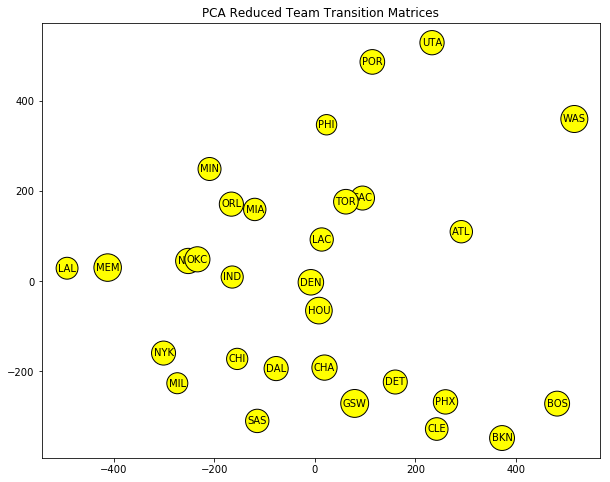

In [23]:
ts = []
transs = []
for p, mat in team_to_transitions.items():
    ts.append(p)
    transs.append(mat)
t = PCA(n_components=2)
td=t.fit_transform(transs)

plt.figure(figsize=(10, 8))
plt.scatter(td[:, 0], td[:, 1])

for team, x, y in zip(ts, td[:, 0], td[:, 1]):
    plt.annotate(team_to_abbrev[team], xy=(x, y), xytext=(0, 0), textcoords='offset points', ha='center', va='center', 
                 bbox=dict(boxstyle='circle,pad=0.2', fc='yellow', alpha=1))
plt.title("PCA Reduced Team Transition Matrices")
plt.show()

### Display heatmap of GSW aggregated transition matrices

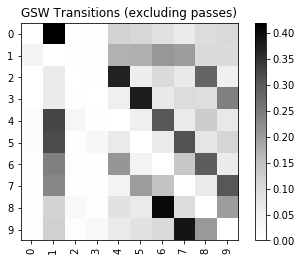

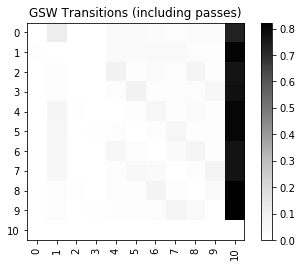

In [93]:
plt.title("GSW Transitions (excluding passes)")
plt.imshow(normalized_nopass, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(normalized_nopass.shape[0]), range(normalized_nopass.shape[0]), rotation=90)
plt.yticks(range(normalized_nopass.shape[0]), range(normalized_nopass.shape[0]))
plt.show()

plt.title("GSW Transitions (including passes)")
plt.imshow(normalized_pass, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(normalized_pass.shape[0]), range(normalized_pass.shape[0]), rotation=90)
plt.yticks(range(normalized_pass.shape[0]), range(normalized_pass.shape[0]))
plt.show()

### Display heatmap of PHI aggregated transition matrices

In [96]:
dists = distances_to_ball("Philadelphia 76ers", p=False)
bh = get_ballhandlers(dists)

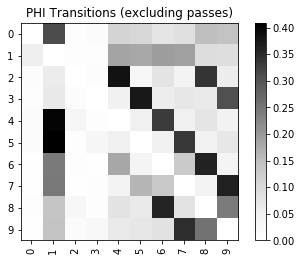

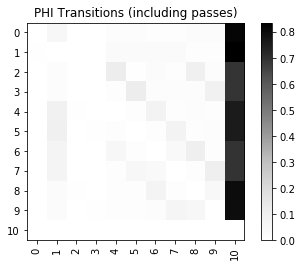

In [97]:
bh_trans = ballhandler_transitions("Philadelphia 76ers", bh, p=False)

for team, players in bh_trans.items():
    total = np.zeros((10, 10))
    for p, trans in players.items():
        nptrans = np.array(trans[0])
        total += nptrans[:10, :10]
    normalized_nopass = normalize(total, axis=1, norm="l1")
    
for team, players in bh_trans.items():
    total = np.zeros((11, 11))
    for p, trans in players.items():
        total += trans[0]
    normalized_pass = normalize(total, axis=1, norm="l1")
    
plt.title("PHI Transitions (excluding passes)")
plt.imshow(normalized_nopass, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(normalized_nopass.shape[0]), range(normalized_nopass.shape[0]), rotation=90)
plt.yticks(range(normalized_nopass.shape[0]), range(normalized_nopass.shape[0]))
plt.show()

plt.title("PHI Transitions (including passes)")
plt.imshow(normalized_pass, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(normalized_pass.shape[0]), range(normalized_pass.shape[0]), rotation=90)
plt.yticks(range(normalized_pass.shape[0]), range(normalized_pass.shape[0]))
plt.show()

### Outputs distances travelled of team

In [17]:
def distance_travelled(team_name, num_games=None, p=True):
    dist_dict = {}
    seen_moments = set()
    abbrev = team_to_abbrev[team_name]

    count = 0
    for root, dirs, files in os.walk(".\data"):
        if abbrev in root:
            for fil in files:
                with open(os.path.join(root, fil)) as f:
                    if num_games and count >= num_games:
                        return dist_dict, count
                    if p:
                        print root
                    count += 1
                    for l in f:
                        line = json.loads(l)
                        for i in range(len(line["events"])):
                            for mom in line["events"][i]["moments"]:
                                mom_tuple = (mom[2], mom[3], mom[5][0][2], mom[5][0][3])
                                for val in mom[5]:
                                    player = val[1]
                                    if player != -1:
                                        team = val[0]
                                        if team not in dist_dict:
                                            dist_dict[team] = {}
                                        if player not in dist_dict[team]:
                                            dist_dict[team][player] = [0, val[2], val[3]]
                                        else:
                                            if mom_tuple not in seen_moments:
                                                dist = distance(val[2], val[3], dist_dict[team][player][1], dist_dict[team][player][2])
                                                dist_dict[team][player][0] += dist
                                            dist_dict[team][player][1] = val[2]
                                            dist_dict[team][player][2] = val[3]
                                seen_moments.add(mom_tuple)
    return dist_dict, count

In [18]:
team_dists = json.load(open("team_to_dists.json"))

### Find distances travelled by players per game

[(u'Kentavious Caldwell-Pope', 16665.397539864014), (u'Jimmy Butler', 16489.557476435126), (u'DeMar DeRozan', 16027.678083786375), (u'Gordon Hayward', 15918.887332717994), (u'Kemba Walker', 15788.279068328164), (u'Paul George', 15771.031353216613), (u'CJ McCollum', 15630.11353249026), (u'Khris Middleton', 15457.941732033589), (u'Brandon Knight', 15431.782210659034), (u'Marcus Morris', 15399.744096126158)]
[(u'Charlotte Hornets', 111050.84730648821), (u'Philadelphia 76ers', 110039.11274283711), (u'Portland Trail Blazers', 108936.19929515265), (u'Golden State Warriors', 108783.74764164232), (u'Sacramento Kings', 108716.60665601384), (u'Utah Jazz', 108316.26835949568), (u'Los Angeles Clippers', 106823.81733467516), (u'Los Angeles Lakers', 106690.63499003825), (u'Orlando Magic', 106675.7368545042), (u'Boston Celtics', 106491.54940869685)]
331


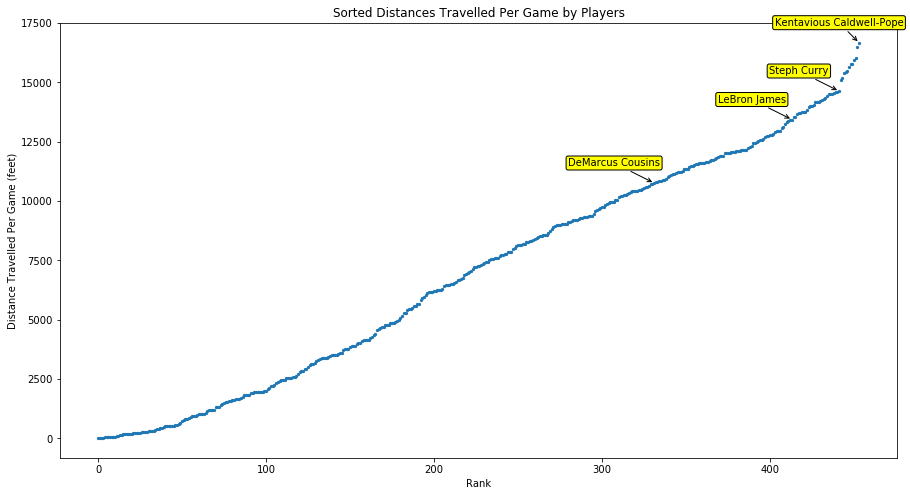

In [19]:
player_avg = []
team_avg = []
for team, players in team_dists.items():
    team_total = 0
    for player, dist in players.items():
        if player != "count" and int(player) != 0:
            player_avg.append((id_to_player[int(player)], dist[0]/players["count"]))
            team_total += dist[0]
    team_avg.append((team, team_total/players["count"]))
print sorted(player_avg, reverse=True, key=lambda x:x[1])[:10]
print sorted(team_avg, reverse=True, key=lambda x:x[1])[:10]
plt.figure(figsize=(15, 8))
print [p[0] for p in sorted(player_avg, key=lambda x:x[1])].index("DeMarcus Cousins")
sorted_avgs = [p[1] for p in sorted(player_avg, key=lambda x:x[1])]
plt.scatter(range(len(player_avg)), sorted_avgs, s=5)
plt.ylabel("Distance Travelled Per Game (feet)")
plt.xlabel("Rank")
plt.title("Sorted Distances Travelled Per Game by Players")
plt.annotate("Kentavious Caldwell-Pope", xy=(range(len(player_avg))[-1], sorted_avgs[-1]), xytext=(-20, 20), 
             textcoords='offset points', ha='center', va='center', 
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1), 
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.annotate("Steph Curry", xy=(range(len(player_avg))[441], sorted_avgs[441]), xytext=(-40, 20), 
             textcoords='offset points', ha='center', va='center', 
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1), 
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.annotate("LeBron James", xy=(range(len(player_avg))[413], sorted_avgs[413]), xytext=(-40, 20), 
             textcoords='offset points', ha='center', va='center', 
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1), 
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.annotate("DeMarcus Cousins", xy=(range(len(player_avg))[331], sorted_avgs[331]), xytext=(-40, 20), 
             textcoords='offset points', ha='center', va='center', 
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1), 
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.show()

### Distances travelled by teams per game

Correlation Coefficient: -0.301808051121, P-value: 0.10504290953


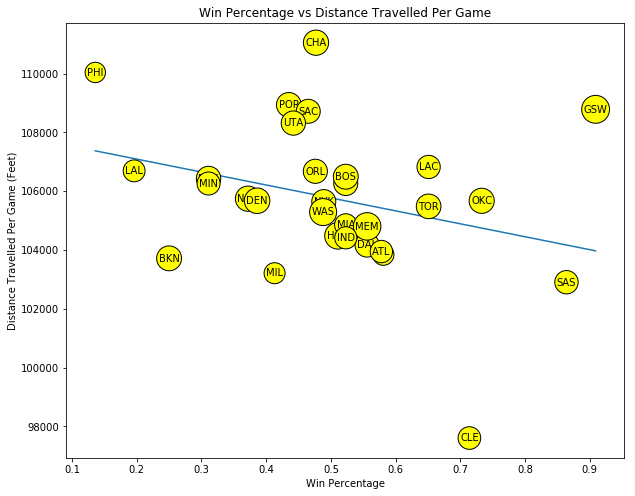

In [20]:
winpcts = [team_to_winpct[tup[0]] for tup in team_avg]
distances = [tup[1] for tup in team_avg]
teams = [team_to_abbrev[tup[0]] for tup in team_avg]

corr = scipy.stats.pearsonr(distances, winpcts)
print "Correlation Coefficient: {}, P-value: {}".format(corr[0], corr[1])

plt.figure(figsize=(10, 8))
plt.scatter(winpcts, distances, marker='o')

for team, x, y in zip(teams, winpcts, distances):
    plt.annotate(team, xy=(x, y), xytext=(0, 0), textcoords='offset points', ha='center', va='center', 
                 bbox=dict(boxstyle='circle,pad=0.2', fc='yellow', alpha=1))
plt.plot(np.unique(winpcts), np.poly1d(np.polyfit(winpcts, distances, 1))(np.unique(winpcts)))
plt.title("Win Percentage vs Distance Travelled Per Game")
plt.xlabel("Win Percentage")
plt.ylabel("Distance Travelled Per Game (Feet)")
plt.show()

### Number of possessions per game for each team

In [21]:
def count_possessions(dists, bhs, team):
    pos = 0
    last_pos = [bh[2] for bh in bhs[:45]]
    handler = None
    for bh in bhs[45:]:
        if bh[2] != handler:
            if all(bh[2] == pos for pos in last_pos):
                handler = bh[2]
                if handler == team_to_id[team]:
                    pos += 1
        last_pos = last_pos[1:]+[bh[2]]
    return pos

In [22]:
team_to_poss = json.load(open("team_to_poss.json"))

Correlation Coefficient: -0.210232619375, P-value: 0.264815432582


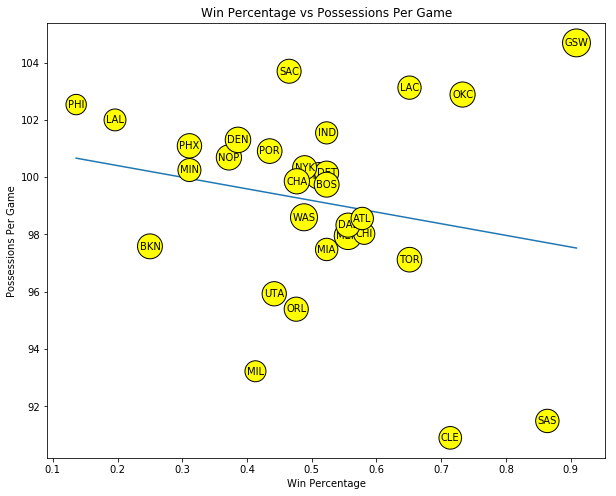

In [23]:
winpcts = []
possessions = []
labels = []
for team, poss in team_to_poss.items():
    winpcts.append(team_to_winpct[team])
    possessions.append(poss)
    labels.append(team_to_abbrev[team])
    
corr = scipy.stats.pearsonr(possessions, winpcts)
print "Correlation Coefficient: {}, P-value: {}".format(corr[0], corr[1])
    
plt.figure(figsize=(10, 8))
plt.scatter(winpcts, possessions, marker='o')

for team, x, y in zip(labels, winpcts, possessions):
    plt.annotate(team, xy=(x, y), xytext=(0, 0), textcoords='offset points', ha='center', va='center', 
                 bbox=dict(boxstyle='circle,pad=0.2', fc='yellow', alpha=1))
plt.plot(np.unique(winpcts), np.poly1d(np.polyfit(winpcts, possessions, 1))(np.unique(winpcts)))
plt.title("Win Percentage vs Possessions Per Game")
plt.xlabel("Win Percentage")
plt.ylabel("Possessions Per Game")
plt.show()

### Number of passes per game for each team

In [24]:
def count_passes(bhs, team):
    num_passes = 0
    last_bh = [bh[0] for bh in bhs[:30]]
    handler = None
    handler_team = None
    for bh in bhs[30:]:
        if bh[0] != handler:
            if all(bh[0] == ballhandler for ballhandler in last_bh):
                handler = bh[0]
                handler_team = bh[2]
                if handler_team == team_to_id[team]:
                    num_passes += 1
        last_bh = last_bh[1:]+[bh[0]]
    return num_passes

In [25]:
team_to_passes = json.load(open("team_to_passes.json"))
for team, players in team_dists.items():
    if team not in team_to_passes:
        count = players["count"]
        dists = distances_to_ball(team, team_specific=False, p=False)
        bhs = get_ballhandlers(dists)
        av = count_passes(bhs, team)/float(count)
        print av
        team_to_passes[team] = av
        json.dump(team_to_passes, open("team_to_passes.json", "w"))

Correlation Coefficient: -0.0930397671784, P-value: 0.624835249748


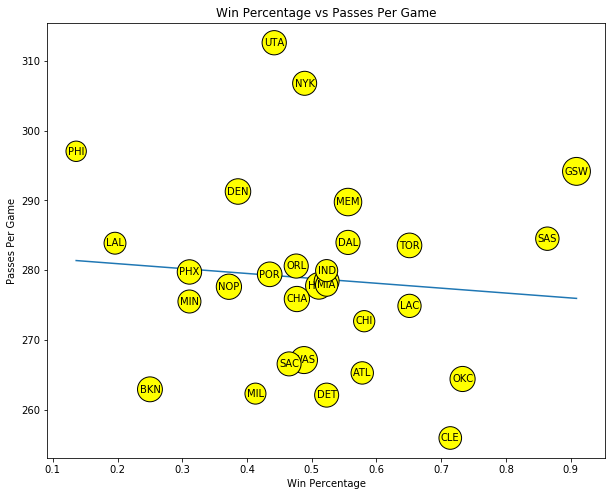

In [26]:
winpcts = []
passes = []
labels = []
for team, t_passes in team_to_passes.items():
    winpcts.append(team_to_winpct[team])
    passes.append(t_passes)
    labels.append(team_to_abbrev[team])
    
corr = scipy.stats.pearsonr(passes, winpcts)
print "Correlation Coefficient: {}, P-value: {}".format(corr[0], corr[1])
    
plt.figure(figsize=(10, 8))
plt.scatter(winpcts, passes, marker='o')

for team, x, y in zip(labels, winpcts, passes):
    plt.annotate(team, xy=(x, y), xytext=(0, 0), textcoords='offset points', ha='center', va='center', 
                 bbox=dict(boxstyle='circle,pad=0.2', fc='yellow', alpha=1))
plt.plot(np.unique(winpcts), np.poly1d(np.polyfit(winpcts, passes, 1))(np.unique(winpcts)))
plt.title("Win Percentage vs Passes Per Game")
plt.xlabel("Win Percentage")
plt.ylabel("Passes Per Game")
plt.show()

### Opponent distance travelled

In [27]:
def distance_travelled_opponent(team_name, ballhandlers, num_games=None, p=True):
    abbrev = team_to_abbrev[team_name]
    team_id = team_to_id[team_name]
    dist_dict = {}
    seen_moments = set()

    moment_num = 0
    count = 0
    for root, dirs, files in os.walk(".\data"):
        if abbrev in root:
            for fil in files:
                with open(os.path.join(root, fil)) as f:
                    if num_games and count >= num_games:
                        return dist_dict, count
                    if p:
                        print root
                    count += 1
                    for l in f:
                        line = json.loads(l)
                        for i in range(len(line["events"])):
                            for mom in line["events"][i]["moments"]:
                                mom_tuple = (mom[2], mom[3], mom[5][0][2], mom[5][0][3])
                                if mom_tuple not in seen_moments:
                                    if moment_num >= len(ballhandlers):
                                        return dist_dict, count
                                    xs_left = [val[2] < 47 for val in mom[5]]
                                    xs_right = [val[2] >= 47 for val in mom[5]]
                                    if (all(xs_left) or all(xs_right)) and ballhandlers[moment_num][2] and \
                                    id_to_team[ballhandlers[moment_num][2]] == team_name:
                                        for val in mom[5]:
                                            player = val[1]
                                            if player != -1 and player != 0:
                                                team = val[0]
                                                team_n = id_to_team[team]
                                                if team_n != team_name:
                                                    if team not in dist_dict:
                                                        dist_dict[team] = {}
                                                    if player not in dist_dict[team]:
                                                        dist_dict[team][player] = [0, val[2], val[3]]
                                                    else:
                                                        dist = distance(val[2], val[3], dist_dict[team][player][1], dist_dict[team][player][2])
                                                        dist_dict[team][player][0] += dist
                                                        dist_dict[team][player][1] = val[2]
                                                        dist_dict[team][player][2] = val[3]
                                    moment_num += 1
                                    seen_moments.add(mom_tuple)
    return dist_dict, count

Correlation Coefficient: -0.300466801197, P-value: 0.106673885869


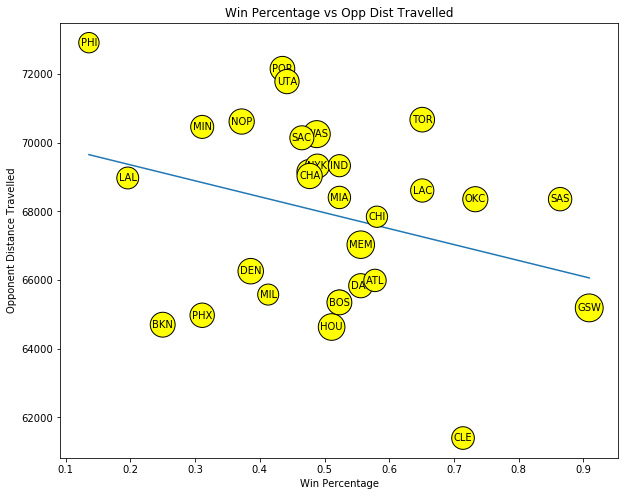

Correlation Coefficient: -0.156455235797, P-value: 0.409013800623


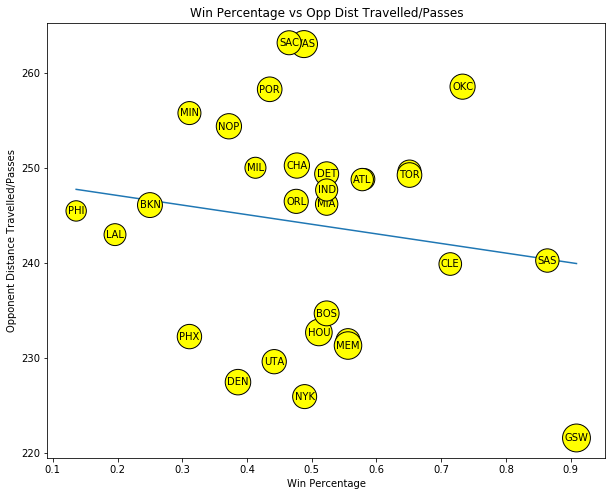

In [29]:
team_to_opp_dist = json.load(open("team_to_opp_dist.json"))
winpcts = []
opp_dist = []
labels = []
opp_dist_by_passes = []
for team, t_dist in team_to_opp_dist.items():
    winpcts.append(team_to_winpct[team])
    opp_dist.append(t_dist)
    opp_dist_by_passes.append(t_dist/team_to_passes[team])
    labels.append(team_to_abbrev[team])
    
corr = scipy.stats.pearsonr(opp_dist, winpcts)
print "Correlation Coefficient: {}, P-value: {}".format(corr[0], corr[1])
    
plt.figure(figsize=(10, 8))
plt.scatter(winpcts, opp_dist, marker='o')

for team, x, y in zip(labels, winpcts, opp_dist):
    plt.annotate(team, xy=(x, y), xytext=(0, 0), textcoords='offset points', ha='center', va='center', 
                 bbox=dict(boxstyle='circle,pad=0.2', fc='yellow', alpha=1))
plt.plot(np.unique(winpcts), np.poly1d(np.polyfit(winpcts, opp_dist, 1))(np.unique(winpcts)))
plt.title("Win Percentage vs Opp Dist Travelled")
plt.xlabel("Win Percentage")
plt.ylabel("Opponent Distance Travelled")
plt.show()

corr = scipy.stats.pearsonr(opp_dist_by_passes, winpcts)
print "Correlation Coefficient: {}, P-value: {}".format(corr[0], corr[1])

plt.figure(figsize=(10, 8))
plt.scatter(winpcts, opp_dist_by_passes, marker='o')

for team, x, y in zip(labels, winpcts, opp_dist_by_passes):
    plt.annotate(team, xy=(x, y), xytext=(0, 0), textcoords='offset points', ha='center', va='center', 
                 bbox=dict(boxstyle='circle,pad=0.2', fc='yellow', alpha=1))
plt.plot(np.unique(winpcts), np.poly1d(np.polyfit(winpcts, opp_dist_by_passes, 1))(np.unique(winpcts)))
plt.title("Win Percentage vs Opp Dist Travelled/Passes")
plt.xlabel("Win Percentage")
plt.ylabel("Opponent Distance Travelled/Passes")
plt.show()

### Examples of transition matrices

In [70]:
trans = transitions("Los Angeles Clippers", num_games=1)

.\data\01.02.2016.PHI.at.LAC


In [73]:
for team, players in trans.items():
    print id_to_team[team]
    for p, t in players.items():
        if id_to_player[p] == "JJ Redick" or id_to_player[p] == "DeAndre Jordan":
            print id_to_player[p]
            n = normalize(t[0][:10, :10], axis=1, norm="l1")
            for row in n:
                print np.around(row, decimals=3)

Los Angeles Clippers
JJ Redick
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.     0.     0.     0.     0.297  0.281  0.219  0.188  0.016  0.   ]
[ 0.     0.     0.     0.     0.529  0.     0.059  0.     0.412  0.   ]
[ 0.     0.     0.     0.     0.     0.423  0.038  0.     0.     0.538]
[ 0.     0.214  0.171  0.     0.     0.014  0.586  0.     0.014  0.   ]
[ 0.     0.31   0.     0.155  0.     0.     0.017  0.466  0.     0.052]
[ 0.     0.135  0.     0.008  0.302  0.     0.     0.151  0.397  0.008]
[ 0.     0.133  0.     0.01   0.01   0.238  0.162  0.     0.01   0.438]
[ 0.014  0.     0.068  0.     0.027  0.     0.658  0.     0.     0.233]
[ 0.     0.     0.     0.185  0.012  0.025  0.037  0.58   0.16   0.   ]
DeAndre Jordan
[ 0.     0.571  0.     0.     0.286  0.     0.     0.143  0.     0.   ]
[ 0.054  0.     0.     0.     0.249  0.097  0.346  0.238  0.016  0.   ]
[ 0.     0.333  0.     0.     0.667  0.     0.     0.     0.     0.   ]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.05

In [63]:
dists = distances_to_ball("New York Knicks", team_specific=False, num_games=1)
bhs = get_ballhandlers(dists)
transitions_m = ballhandler_transitions("New York Knicks", bhs, num_games=1)

.\data\01.01.2016.NYK.at.CHI
.\data\01.01.2016.NYK.at.CHI


In [64]:
for team, players in transitions_m.items():
    print id_to_team[team]
    for p, trans in players.items():
        if id_to_player[p] == "Kristaps Porzingis" or id_to_player[p] == "Jose Calderon":
            print id_to_player[p]
            for row in trans[0]:
                row[0] = 0
            n = normalize(trans[0][:10, :10], axis=1, norm="l1")
            for row in n:
                print np.around(row, decimals=3)

New York Knicks
Kristaps Porzingis
[ 0.     0.25   0.     0.     0.     0.083  0.083  0.     0.417  0.167]
[ 0.    0.    0.    0.05  0.3   0.1   0.1   0.1   0.2   0.15]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.     0.778  0.     0.     0.     0.     0.111  0.111  0.     0.   ]
[ 0.     0.667  0.     0.     0.     0.     0.167  0.167  0.     0.   ]
[ 0.   0.5  0.   0.   0.2  0.   0.   0.   0.3  0. ]
[ 0.   0.6  0.   0.   0.   0.4  0.   0.   0.   0. ]
[ 0.     0.538  0.     0.     0.077  0.077  0.308  0.     0.     0.   ]
[ 0.   0.6  0.   0.   0.   0.2  0.2  0.   0.   0. ]
Jose Calderon
[ 0.   0.5  0.   0.   0.   0.5  0.   0.   0.   0. ]
[ 0.     0.     0.     0.043  0.087  0.174  0.478  0.174  0.     0.043]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
[ 0.   0.3  0.   0.   0.   0.2  0.5  0.   0.   0. ]
[ 0.    0.25  0.    0.    0.    0.    0.1   0.65  0.    0.  ]
[ 0.     0.053  0.     0.     0.079  0.

### Court heatmap for locations per game

In [27]:
def generate_heatmap(team_name, team_specific=True, num_games=None, p=True):
    xs = []
    ys = []
    seen_moments = set()
    abbrev = team_to_abbrev[team_name]

    count = 0
    for root, dirs, files in os.walk(".\data"):
        if abbrev in root:
            for fil in files:
                with open(os.path.join(root, fil)) as f:
                    if num_games and count >= num_games:
                        return xs, ys
                    if p:
                        print root
                    count += 1
                    for l in f:
                        line = json.loads(l)
                        for i in range(len(line["events"])):
                            for mom in line["events"][i]["moments"]:
                                mom_tuple = (mom[2], mom[3], mom[5][0][2], mom[5][0][3])
                                for val in mom[5]:
                                    player = val[1]
                                    if player != -1 and player != 0:
                                        team = val[0]
                                        if mom_tuple not in seen_moments:
                                            if not team_specific or (id_to_team[team] == team_name and team_specific):
                                                xs.append(val[2])
                                                ys.append(val[3])
                                seen_moments.add(mom_tuple)
    return xs, ys

In [ ]:
xs, ys = generate_heatmap("Phoenix Suns", team_specific = False)

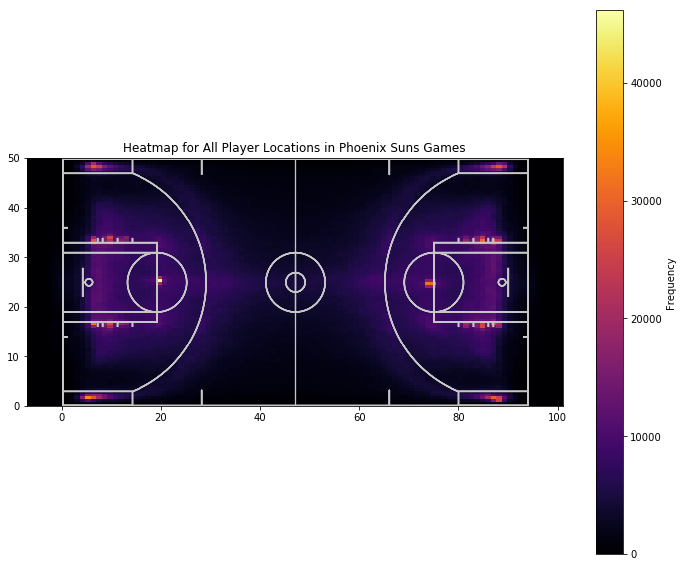

In [84]:
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(1,1,1)
# plt.hexbin(xs, ys, cmap="inferno")
plt.hist2d(xs, ys, bins=100, cmap="inferno")
cb = plt.colorbar()
cb.set_label("Frequency")
plt.imshow(court, zorder=0, extent=[0,94,50,0])
plt.xlim([-7, 101])
plt.ylim([0, 50])
plt.title("Heatmap for All Player Locations in Phoenix Suns Games")
plt.show()